In [ ]:
import librosa
import librosa.display
import IPython.display as ipd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import numpy as np

DB_EPS = 1e-6
EPS = 1e-9

In [ ]:
import os

def get_files(path):
  ret = []
  for root, _, files in os.walk(path, topdown=False):
    for file in files:
      ret.append(os.path.join(root,file))
  return ret

In [ ]:
directory = '/content/drive/MyDrive/psaltica_nepsis_ch/utrenia_8_glasuri_ierom_macarie'
tones = {tone : {'dir' : directory + '/utrenia-glas' + str(tone) + '-macarie/Inregistrari', 'files' : None} for tone in list(range(1, 8 + 1))}

In [ ]:
tones

{1: {'dir': '/content/drive/MyDrive/psaltica_nepsis_ch/utrenia_8_glasuri_ierom_macarie/utrenia-glas1-macarie/Inregistrari',
  'files': None},
 2: {'dir': '/content/drive/MyDrive/psaltica_nepsis_ch/utrenia_8_glasuri_ierom_macarie/utrenia-glas2-macarie/Inregistrari',
  'files': None},
 3: {'dir': '/content/drive/MyDrive/psaltica_nepsis_ch/utrenia_8_glasuri_ierom_macarie/utrenia-glas3-macarie/Inregistrari',
  'files': None},
 4: {'dir': '/content/drive/MyDrive/psaltica_nepsis_ch/utrenia_8_glasuri_ierom_macarie/utrenia-glas4-macarie/Inregistrari',
  'files': None},
 5: {'dir': '/content/drive/MyDrive/psaltica_nepsis_ch/utrenia_8_glasuri_ierom_macarie/utrenia-glas5-macarie/Inregistrari',
  'files': None},
 6: {'dir': '/content/drive/MyDrive/psaltica_nepsis_ch/utrenia_8_glasuri_ierom_macarie/utrenia-glas6-macarie/Inregistrari',
  'files': None},
 7: {'dir': '/content/drive/MyDrive/psaltica_nepsis_ch/utrenia_8_glasuri_ierom_macarie/utrenia-glas7-macarie/Inregistrari',
  'files': None},
 8: {'

In [ ]:
for tone in tones.keys():
  tones[tone]['files'] = get_files(tones[tone]['dir'])
tones[6]['files']

['/content/drive/MyDrive/psaltica_nepsis_ch/utrenia_8_glasuri_ierom_macarie/utrenia-glas6-macarie/Inregistrari/6. 1 Dumnezeu este D.m4a',
 '/content/drive/MyDrive/psaltica_nepsis_ch/utrenia_8_glasuri_ierom_macarie/utrenia-glas6-macarie/Inregistrari/6.9 Ceea ce eşti mai cinstită.m4a',
 '/content/drive/MyDrive/psaltica_nepsis_ch/utrenia_8_glasuri_ierom_macarie/utrenia-glas6-macarie/Inregistrari/6.8 Toată suflarea ante Ev.m4a',
 '/content/drive/MyDrive/psaltica_nepsis_ch/utrenia_8_glasuri_ierom_macarie/utrenia-glas6-macarie/Inregistrari/6. 15 Preabinecuvântată eşti.m4a',
 '/content/drive/MyDrive/psaltica_nepsis_ch/utrenia_8_glasuri_ierom_macarie/utrenia-glas6-macarie/Inregistrari/6.2 Troparele.m4a',
 '/content/drive/MyDrive/psaltica_nepsis_ch/utrenia_8_glasuri_ierom_macarie/utrenia-glas6-macarie/Inregistrari/6.3 Primul rând de sed.m4a',
 '/content/drive/MyDrive/psaltica_nepsis_ch/utrenia_8_glasuri_ierom_macarie/utrenia-glas6-macarie/Inregistrari/6.4 Al doilea rând de sed.m4a',
 '/

In [186]:
kBinsPerOctave = 12
kJump = int(4/3 * kBinsPerOctave)

In [ ]:
def debug_frequencies(freqs):
  print("size=" + str(len(freqs)))
  for index, elem in enumerate(freqs):
    c = '\n' if index % 8 == 0 else ' || '
    print(str(index) + " -> " + str(int(elem)),end=c)
  print('')
  pass


def debug(curr, b, e):
  for x in curr[b:e]:
    for elem in x:
      print(elem, end=',')
    print('')
  pass

def plot_lms(lms_, sr_):
  plt.figure(figsize=(30, 10))
  librosa.display.specshow(lms_, 
                          x_axis="time",
                          y_axis="mel", 
                          sr=sr_)
  plt.colorbar(format="%+2.f")
  plt.show()
  pass

def lower_bound(arr, needle):
# Lower-bound to find frequencies
  n = len(arr)
  lower, half = 0, n // 2
  while half:
    middle = lower + half;
    lower = middle if arr[middle] <= needle else lower
    n -= half
    half = n // 2
  return lower

def encode_melody(melody):
  return np.diff(melody) + (kBinsPerOctave - 1)

In [182]:
# TODO: use also CQT_CHROMA!!!
def analyze_audio(filename):
  scale, sr = librosa.load(filename)
  fmin = librosa.midi_to_hz(36) # C2
  fmax = librosa.midi_to_hz(84) # C6 (not used)

  # TODO: put 24 bins per octave
  X = librosa.cqt(scale, sr=sr, fmin=fmin, bins_per_octave=kBinsPerOctave)  
  kBins = X.shape[0]
  print("initial=" + str(X.shape))

  freqs = librosa.cqt_frequencies(n_bins=kBins, fmin=fmin)
  pos_fmax = lower_bound(freqs, fmax)
  
  print("pos_fmax=" + str(pos_fmax) + " val=" + str(freqs[pos_fmax]))
  debug_frequencies(freqs)
  
  orig_logX = librosa.amplitude_to_db(abs(X))
  
  # Transpose
  logX = np.transpose(orig_logX).copy()

  # Zero-out minus db
  logX[logX < 0] = 0

  # Zero-out > fmax
  logX[:,(1 + pos_fmax):] = 0

  # Clear empty columns
  logX = logX[~np.all(logX < DB_EPS, axis=1)]

  # Scale
  scaler = MinMaxScaler()
  logX = scaler.fit_transform(logX)
  
  print("transofrmed=" + str(logX.shape))
  
  plt.figure(figsize=(15, 5))
  librosa.display.specshow(logX.T, sr=sr, x_axis='time', y_axis='cqt_note', fmin=fmin, cmap='coolwarm')
  plt.colorbar(format='%+2.0f dB')
  plt.show()

  melody = []
  for index in range(len(logX)):
    tmp = np.zeros(kBinsPerOctave)
    for bin in range(kBins):
      tmp[bin % kBinsPerOctave] += logX[index][bin]
    max_pos = np.argmax(tmp)
    assert 0 <= max_pos and max_pos < kBinsPerOctave
    melody.append(max_pos)
  return sr, logX, np.asarray(melody)

In [ ]:
filename=tones[1]['files'][0]
ipd.Audio(filename)

/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


initial=(84, 1761)
pos_fmax=48 val=1046.5022612023945
size=84
0 -> 65
1 -> 69 || 2 -> 73 || 3 -> 77 || 4 -> 82 || 5 -> 87 || 6 -> 92 || 7 -> 97 || 8 -> 103
9 -> 109 || 10 -> 116 || 11 -> 123 || 12 -> 130 || 13 -> 138 || 14 -> 146 || 15 -> 155 || 16 -> 164
17 -> 174 || 18 -> 184 || 19 -> 195 || 20 -> 207 || 21 -> 219 || 22 -> 233 || 23 -> 246 || 24 -> 261
25 -> 277 || 26 -> 293 || 27 -> 311 || 28 -> 329 || 29 -> 349 || 30 -> 369 || 31 -> 391 || 32 -> 415
33 -> 439 || 34 -> 466 || 35 -> 493 || 36 -> 523 || 37 -> 554 || 38 -> 587 || 39 -> 622 || 40 -> 659
41 -> 698 || 42 -> 739 || 43 -> 783 || 44 -> 830 || 45 -> 879 || 46 -> 932 || 47 -> 987 || 48 -> 1046
49 -> 1108 || 50 -> 1174 || 51 -> 1244 || 52 -> 1318 || 53 -> 1396 || 54 -> 1479 || 55 -> 1567 || 56 -> 1661
57 -> 1759 || 58 -> 1864 || 59 -> 1975 || 60 -> 2093 || 61 -> 2217 || 62 -> 2349 || 63 -> 2489 || 64 -> 2637
65 -> 2793 || 66 -> 2959 || 67 -> 3135 || 68 -> 3322 || 69 -> 3519 || 70 -> 3729 || 71 -> 3951 || 72 -> 4186
73 -> 4434 |

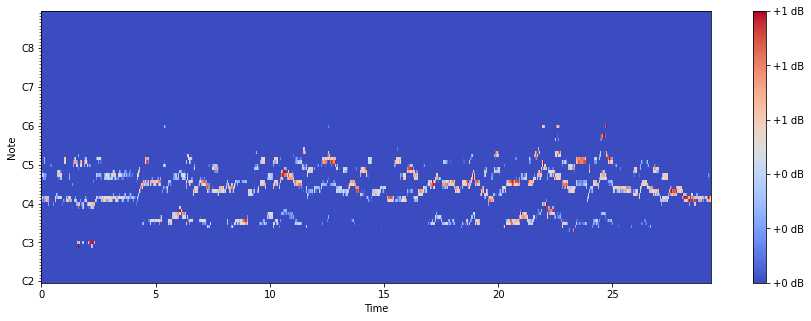

11
-11


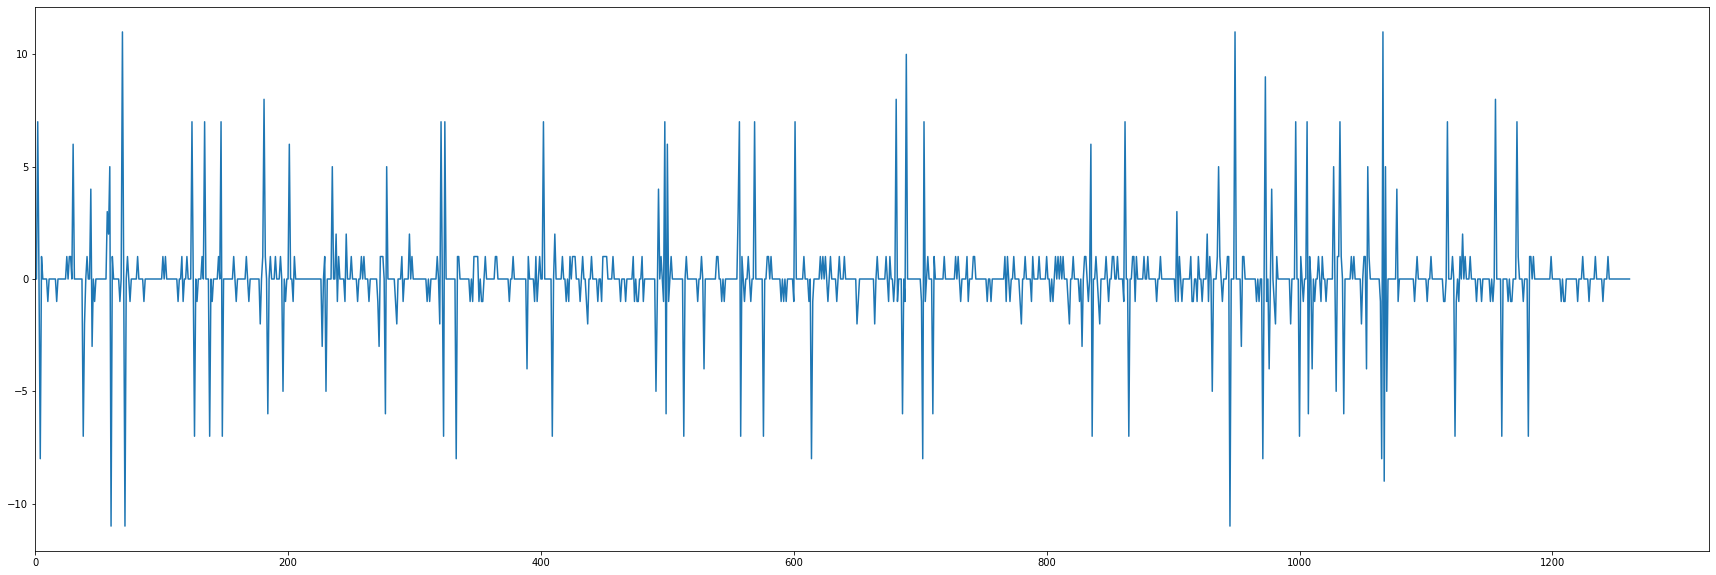

In [185]:
sr, scale, melody = analyze_audio(filename)
import json
encode_melody(melody)
with open('data.txt', 'w') as f:
  json.dump(data, f, ensure_ascii=False)

melody_diff = np.diff(melody)
print(max(melody_diff))
print(min(melody_diff))
plt.figure(figsize=(30, 10))
plt.plot(melody_diff)
plt.xlim(xmin=0)
plt.show()

In [ ]:
plt.figure(figsize=(30, 10))
plt.plot(melody)
plt.xlim(xmin=0)
plt.show()

In [ ]:
def generate_training_sequences(sequence_length):
  """Create input and output data samples for training. Each sample is a sequence.

  :param sequence_length (int): Length of each sequence. With a quantisation at 16th notes, 64 notes equates to 4 bars

  :return inputs (ndarray): Training inputs
  :return targets (ndarray): Training targets
  """

  # load songs and map them to int
  songs = load(SINGLE_FILE_DATASET)
  int_songs = convert_songs_to_int(songs)

  inputs = []
  targets = []

  # generate the training sequences
  num_sequences = len(int_songs) - sequence_length
  for i in range(num_sequences):
      inputs.append(int_songs[i : i + sequence_length])
      targets.append(int_songs[i + sequence_length])

  # one-hot encode the sequences
  vocabulary_size = len(set(int_songs))
  # inputs size: (# of sequences, sequence length, vocabulary size)
  inputs = keras.utils.to_categorical(inputs, num_classes=vocabulary_size)
  targets = np.array(targets)

  print(f"There are {len(inputs)} sequences.")

  return inputs, targets

In [ ]:
import tensorflow.keras as keras
from preprocess import generate_training_sequences, SEQUENCE_LENGTH

# TODO: check the best one!
kSequenceLength = 256

kOutputUnits = 38
kNumUnits = [256]
kLoss = "sparse_categorical_crossentropy"
kLearningRate = 0.001
kEpochs = 50
kBatchSize = 64
kSaveModelPath = "model.h5"

def build_model(output_units, num_units, loss, learning_rate):
    """Builds and compiles model

    :param output_units (int): Num output units
    :param num_units (list of int): Num of units in hidden layers
    :param loss (str): Type of loss function to use
    :param learning_rate (float): Learning rate to apply

    :return model (tf model): The model
    """

    # create the model architecture
    input = keras.layers.Input(shape=(None, output_units))
    x = keras.layers.LSTM(num_units[0])(input)
    x = keras.layers.Dropout(0.2)(x)

    output = keras.layers.Dense(output_units, activation="softmax")(x)

    model = keras.Model(input, output)

    # compile model
    model.compile(loss=loss,
                  optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
                  metrics=["accuracy"])

    model.summary()

    return model


def train(output_units=kOutputUnits, num_units=kNumUnits, loss=kLoss, learning_rate=kLearningRate):
    """Train and save TF model.

    :param output_units (int): Num output units
    :param num_units (list of int): Num of units in hidden layers
    :param loss (str): Type of loss function to use
    :param learning_rate (float): Learning rate to apply
    """

    # generate the training sequences
    inputs, targets = generate_training_sequences(kSequenceLength)

    # build the network
    model = build_model(output_units, num_units, loss, learning_rate)

    # train the model
    model.fit(inputs, targets, epochs=kEpochs, batch_size=kBatchSize)

    # save the model
    model.save(kSaveModelPath)

In [ ]:
train()